## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\admin\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\admin\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\admin\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\admin\Anaconda3\envs\tf\lib\site-packages\tenso

In [2]:
train, test = keras.datasets.cifar10.load_data()

## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [3]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [4]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
PATIENCE=[5,10,25]

In [5]:
# 載入 Callbacks
from keras.callbacks import EarlyStopping
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation accuracy
"""

results = {}

for patience_ in PATIENCE:
    earlystop = EarlyStopping(monitor="val_loss", patience=patience_, verbose=1)

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "patience-%s" % str(patience_)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_____________________________________________________

50000/50000 [==============================] - 10s 196us/step - loss: 1.2713 - accuracy: 0.5621 - val_loss: 1.4955 - val_accuracy: 0.4716
Epoch 12/50
50000/50000 [==============================] - 10s 190us/step - loss: 1.2440 - accuracy: 0.5743 - val_loss: 1.4925 - val_accuracy: 0.4685
Epoch 13/50
50000/50000 [==============================] - 10s 192us/step - loss: 1.2180 - accuracy: 0.5823 - val_loss: 1.4864 - val_accuracy: 0.4717
Epoch 14/50
50000/50000 [==============================] - 10s 190us/step - loss: 1.1928 - accuracy: 0.5904 - val_loss: 1.4720 - val_accuracy: 0.4790
Epoch 15/50
50000/50000 [==============================] - 10s 192us/step - loss: 1.1689 - accuracy: 0.6015 - val_loss: 1.4678 - val_accuracy: 0.4839
Epoch 16/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.1456 - accuracy: 0.6092 - val_loss: 1.4583 - val_accuracy: 0.4835
Epoch 17/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.1219 - accuracy: 0.6195 - va

Epoch 30/50
50000/50000 [==============================] - 10s 201us/step - loss: 0.8468 - accuracy: 0.7220 - val_loss: 1.4848 - val_accuracy: 0.4988
Epoch 31/50
50000/50000 [==============================] - 12s 248us/step - loss: 0.8254 - accuracy: 0.7316 - val_loss: 1.4927 - val_accuracy: 0.4954
Epoch 32/50
50000/50000 [==============================] - 11s 223us/step - loss: 0.8070 - accuracy: 0.7383 - val_loss: 1.5001 - val_accuracy: 0.4988
Epoch 33/50
50000/50000 [==============================] - 10s 193us/step - loss: 0.7873 - accuracy: 0.7456 - val_loss: 1.5206 - val_accuracy: 0.4946
Epoch 34/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.7672 - accuracy: 0.7545 - val_loss: 1.5208 - val_accuracy: 0.4970
Epoch 35/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.7475 - accuracy: 0.7620 - val_loss: 1.5221 - val_accuracy: 0.4980
Epoch 36/50
50000/50000 [==============================] - 10s 193us/step - loss: 0.7263 - accuracy:

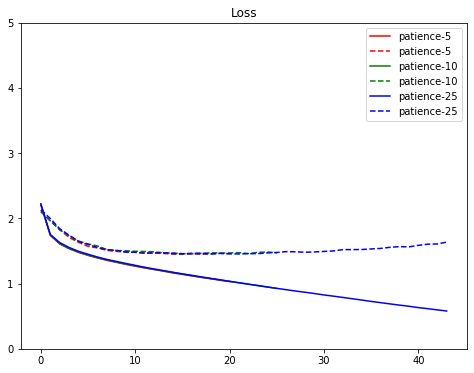

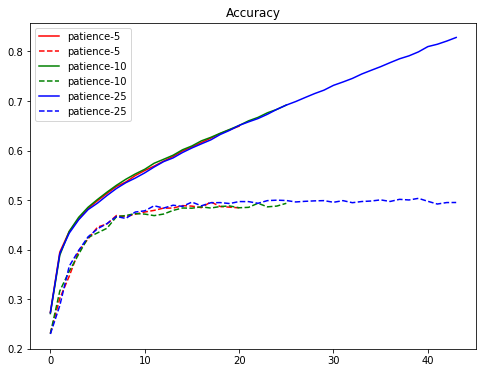

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()